In [1]:
import importlib
import local_utils; importlib.reload(local_utils)
from local_utils import *

Using TensorFlow backend.


Import time: 10.968888521194458
Import time: 9.965896606445312e-05


In [2]:
global_start = time()

In [3]:
train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
test_df = pd.read_csv(DATA_DIR + '/sample_submission_v2.csv')

label_map, inv_label_map, Y = process_labels(train_df)
print("Shape of Y {}".format(Y.shape))

train_folds, valid_folds = stratified_kfold_sampling(Y, n_splits=10, random_state=1000)
print("Shape of train folds {}".format(train_folds.shape))
print("Shape of valid folds {}".format(valid_folds.shape))

image_size = 256

Shape of Y (40479, 17)
Shape of train folds (10,)
Shape of valid folds (10,)


In [15]:
model_name = "deep_model_256x256"

fold_inx = 1
batch_size = 20
all_steps = np.ceil(len(train_df)/batch_size)
train_steps = np.ceil(len(train_folds[fold_inx])/batch_size)
valid_steps = np.ceil(len(valid_folds[fold_inx])/batch_size)
test_steps = np.ceil(len(test_df)/batch_size)

In [5]:
# cache_images(DATA_DIR+"/train_images_"+str(image_size)+".dat", train_df['image_name'].values[train_folds[fold_inx]], DATA_DIR + '/train-jpg', False, image_size, image_size, dtype=np.float32)
# cache_images(DATA_DIR+"/valid_images_"+str(image_size)+".dat", train_df['image_name'].values[valid_folds[fold_inx]], DATA_DIR + '/train-jpg', False, image_size, image_size, dtype=np.float32)

# cache_images(DATA_DIR+"/test_images_"+str(image_size)+"_1.dat", test_df['image_name'].values[:30000], DATA_DIR + '/test-jpg', False, image_size, image_size, dtype=np.float32)
# cache_images(DATA_DIR+"/test_images_"+str(image_size)+"_2.dat", test_df['image_name'].values[30000:], DATA_DIR + '/test-jpg', False, image_size, image_size, dtype=np.float32)

In [6]:
train_array = load_carray(DATA_DIR+'/train_images_'+str(image_size)+'.dat')
valid_array = load_carray(DATA_DIR+'/valid_images_'+str(image_size)+'.dat')

In [7]:
# x_input = Input(shape=(image_size, image_size, 3))

# x = BatchNormalization()(x_input)
# x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(32, (3, 3), activation='relu')(x)
# xm = MaxPooling2D()(x)
# xa = AveragePooling2D()(x)

# xm = BatchNormalization()(xm)
# xm = Conv2D(64, (3, 3), padding='same', activation='relu')(xm)
# xm = Conv2D(64, (3, 3), activation='relu')(xm)
# xm = MaxPooling2D()(xm)

# xm = BatchNormalization()(xm)
# xm = Conv2D(128, (3, 3), padding='same', activation='relu')(xm)
# xm = Conv2D(128, (3, 3), activation='relu')(xm)
# xm = MaxPooling2D()(xm)

# xm = BatchNormalization()(xm)
# xm = Conv2D(256, (3, 3), padding='same', activation='relu')(xm)
# xm = Conv2D(256, (3, 3), activation='relu')(xm)
# xm = GlobalMaxPooling2D()(xm)

# xa = BatchNormalization()(xa)
# xa = Conv2D(64, (3, 3), padding='same', activation='relu')(xa)
# xa = Conv2D(64, (3, 3), activation='relu')(xa)
# xa = AveragePooling2D()(xa)

# xa = BatchNormalization()(xa)
# xa = Conv2D(128, (3, 3), padding='same', activation='relu')(xa)
# xa = Conv2D(128, (3, 3), activation='relu')(xa)
# xa = AveragePooling2D()(xa)

# xa = BatchNormalization()(xa)
# xa = Conv2D(256, (3, 3), padding='same', activation='relu')(xa)
# xa = Conv2D(256, (3, 3), activation='relu')(xa)
# xa = GlobalAveragePooling2D()(xa)

# x = concatenate([xm, xa])

# x = Dense(512, activation='relu')(x)

# x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)

# x_output = Dense(17, activation='sigmoid')(x)

In [8]:
# model = Model(inputs=x_input, outputs=x_output)

# model_128x128 = load_model(DATA_DIR+'/models/deep_model_1_backup.h5', compile=False)
# model.set_weights(model_128x128.get_weights())

# model.summary()

In [9]:
def getImageDataGenerator():
    return ImageDataGenerator(
                rotation_range=90,
#                 zoom_range=0.1,
#                 width_shift_range=0.1,
#                 height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,)

all_gen = getImageDataGenerator()
train_gen = getImageDataGenerator()
valid_gen = getImageDataGenerator()
test_gen = getImageDataGenerator()

In [10]:
model_checkpoint = ModelCheckpoint(
                DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', 
                monitor='val_fn_loss', 
                verbose=1, 
                save_best_only=True, 
                save_weights_only=False, 
                mode='min',
                period=1)

In [11]:
class F2HistoryGen(Callback):
    def on_train_begin(self, logs={}):
        self.f2_02_scores = [] # TODO
        self.f2_05_scores = []
    def on_epoch_end(self, epoch, logs ={}):
        p_valid = self.model.predict_generator(
            valid_gen.flow(valid_array, None, batch_size=batch_size, shuffle=False), 
            valid_steps)
        y_val = Y[valid_folds[fold_inx]]
        f2_02 = f2_score(y_val, np.array(p_valid), 0.2)
        f2_05 = f2_score(y_val, np.array(p_valid), 0.5)
        print()
        print("F2 Score (0.2) {}; (0.5) {};".format(f2_02, f2_05))
        self.f2_02_scores.append(f2_02)
        self.f2_05_scores.append(f2_05)
        return
f2_history = F2HistoryGen()

In [12]:
# del model
model = load_model(DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', compile=False)

In [14]:
# opt=optimizers.Adam(lr=0.66e-3, decay=33e-4); epochs=2;
opt=optimizers.Adam(lr=1e-4, decay=33e-5); epochs=3;
# opt=optimizers.Adam(lr=1e-5, decay=33e-6); epochs=3;
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fn_loss, f2, 'accuracy'])

In [16]:
model.fit_generator(
    generator=train_gen.flow(train_array, Y[train_folds[fold_inx]], batch_size=batch_size),
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=valid_gen.flow(valid_array, Y[valid_folds[fold_inx]], batch_size=batch_size, shuffle=False),
    validation_steps=valid_steps,
    callbacks=[f2_history, model_checkpoint])

Epoch 1/3
1821/1822 [============================>.] - ETA: 0s - loss: 0.0916 - fn_loss: 0.1139 - f2: 0.8929 - acc: 0.9646

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



F2 Score (0.2) 0.916180588025179; (0.5) 0.8931420127615413;
Epoch 00000: val_fn_loss improved from inf to 0.11745, saving model to /src/DL/planet_understanding_the_amazon_from_space/data/models/deep_model_256x256_1.h5
1822/1822 [==============================] - 1293s - loss: 0.0916 - fn_loss: 0.1139 - f2: 0.8930 - acc: 0.9646 - val_loss: 0.0962 - val_fn_loss: 0.1175 - val_f2: 0.8936 - val_acc: 0.9649
Epoch 2/3
 597/1822 [========>.....................] - ETA: 804s - loss: 0.0924 - fn_loss: 0.1150 - f2: 0.8922 - acc: 0.9639

KeyboardInterrupt: 

[0.92002606767793693, 0.91873487245541496, 0.91776620180137436]


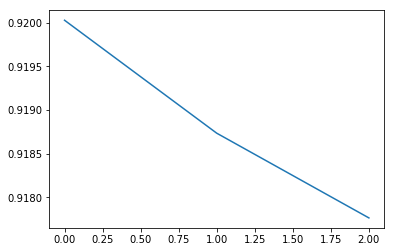

In [24]:
print(f2_history.f2_02_scores)
plt.plot(f2_history.f2_02_scores)
plt.show()

[0.89349361997766152, 0.89386705825851187, 0.89527268361126477]


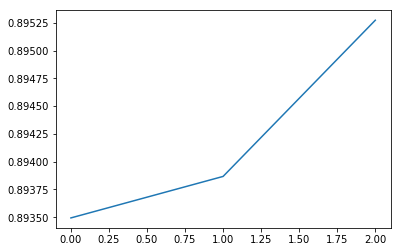

In [21]:
print(f2_history.f2_05_scores)
plt.plot(f2_history.f2_05_scores)
plt.show()

In [ ]:
stop